In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import mutual_info_regression

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Load actual data from the Excel file
actual_data = pd.read_excel("../../DATAFORMODELtrain200824.xlsx")

# Convert 'Date' to datetime format
actual_data['Date'] = pd.to_datetime(actual_data['Date'], format='%m/%d/%Y %H:%M')



In [18]:
# Filter the actual data to the specified date range
start_date = "2024-07-01 23:00"
end_date = "2024-08-20 23:00"
actual_data_filtered = actual_data[(actual_data['Date'] >= start_date) & (actual_data['Date'] <= end_date)]
actual_data_filtered['Date'] = actual_data_filtered['Date'].dt.round('h')

# Load forecast data from the CSV file
forecast_data = pd.read_csv("forecast_results_PriceSK.csv")

# Convert 'ds' to datetime format
forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])
forecast_data['ds'] = forecast_data['ds'].dt.round('H')

# Filter the forecast data to the specified date range
forecast_data_filtered = forecast_data[(forecast_data['ds'] >= start_date) & (forecast_data['ds'] <= end_date)]


/var/folders/v9/fvzjlv1s24vc2tkjy7qscjtm0000gn/T/ipykernel_33398/2971671529.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  actual_data_filtered['Date'] = actual_data_filtered['Date'].dt.round('H')
/var/folders/v9/fvzjlv1s24vc2tkjy7qscjtm0000gn/T/ipykernel_33398/2971671529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data_filtered['Date'] = actual_data_filtered['Date'].dt.round('H')
/var/folders/v9/fvzjlv1s24vc2tkjy7qscjtm0000gn/T/ipykernel_33398/2971671529.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_data['ds'] = forecast_data['ds'].dt.round('H')


In [19]:
# Merge actual and forecasted data on the date column
merged_data = pd.merge(actual_data_filtered[['Date', 'PriceSK']],
                       forecast_data_filtered[['ds', 'yhat']],
                       left_on='Date',
                       right_on='ds',
                       how='inner')

In [20]:
actual_data_filtered.head()

,Date,Y,M,Day,H,PriceHU,PriceSK,PriceRO,PriceCZ,PMIHU,GAS,COAL,CO2,COALTOGAS,WDAY,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,Y2016,Y2017,Y2018,Y2019,Y2020,Y2021,Y2022,Y2023,Y2024,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL
74520,2024-07-02 00:00:00,2024,7,2,1,103.07,89.30,107.20,77.04,51.8,33.505,108.6,66.71,3.241307,1,0,0,0,0,19.690000,28.39,18.1,24.224444,27.563688,34.690000,2314.169900,37846.790000,18.891667,-0.401667,1405.5001,37.49,18.49,0.05,3.90,-999.0,1185.4249,34.43,18.43,0.10,5.90,-999.0,1861.9225,43.15,22.15,0.0,3.23,-999.0,0.0,848.0,87.0,977.3,500.0,0.0,0.0,0.0,0.0,0,348.0,681.0,1159.0,194,940,1062,2860.0,4483.0,1040,0,1066,1066,908,0,0,0,0,0,20015,7017,2480.0,2258.0,4694.0,7685.3,1102.0,1091.0,1119.0,1888.0,10759.0,0.0,0.0,0.0,-541,-255,-235,-1031,1913.0,883,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1087.949914,1019.277556,1880.687718,0.0,0.0,-0.133889,2271.0,811,1067,0,0.0,0.0,4902.435047,1812,27032,9432.0
74521,2024-07-02 01:00:00,2024,7,2,2,103.33,91.54,106.91,75.80,51.8,33.505,108.6,66.71,3.241307,1,0,0,0,0,19.206667,28.39,18.1,24.132083,27.471327,34.206667,2281.926733,33419.913333,18.265833,0.084167,1395.0225,37.35,18.35,0.03,4.11,-999.0,1151.9236,33.94,17.94,0.06,6.47,-999.0,1791.8289,42.33,21.33,0.0,2.71,-999.0,0.0,848.0,87.0,935.0,500.0,0.0,0.0,0.0,0.0,0,348.0,681.0,1159.0,194,940,1062,2872.0,4495.0,1040,0,1066,1066,908,0,0,0,0,0,20120,7017,2480.0,2258.0,4706.0,7655.0,1102.0,977.0,839.0,1885.0,11360.0,0.0,0.0,0.0,-677,-255,-240,-1172,1918.0,958,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1080.583649,1006.389584,1881.113965,0.0,0.0,0.028056,2271.0,1221,1588,0,0.0,0.0,4944.873071,2136,27137,9444.0
74522,2024-07-02 02:00:00,2024,7,2,3,98.53,90.18,99.84,79.89,51.8,33.505,108.6,66.71,3.241307,1,0,0,0,0,18.793333,28.39,18.1,24.051389,27.390633,33.793333,2254.353267,32542.980000,17.675000,0.375000,1372.7025,37.05,18.05,0.04,4.06,-999.0,1116.8964,33.42,17.42,0.00,6.85,-999.0,1756.4481,41.91,20.91,0.0,2.36,-999.0,0.0,848.0,87.0,935.0,500.0,0.0,0.0,0.0,0.0,0,348.0,681.0,1159.0,194,940,1062,2871.0,4494.0,1040,0,1066,1066,908,0,0,0,0,0,20120,7017,2480.0,2258.0,4705.0,7654.0,1102.0,963.0,632.0,1888.0,11372.0,0.0,0.0,0.0,-680,-255,-240,-1175,1976.0,820,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1073.652664,994.493934,1882.198575,0.0,0.0,0.125000,2271.0,1221,1588,0,0.0,0.0,4983.810547,1964,27137,9443.0
74523,2024-07-02 03:00:00,2024,7,2,4,91.75,81.98,95.52,80.01,51.8,33.505,108.6,66.71,3.241307,1,0,0,0,0,18.320000,28.39,18.1,23.974444,27.313688,33.320000,2222.777200,32487.000000,17.150833,0.649167,1354.2400,36.80,17.80,0.03,3.68,-999.0,1059.5025,32.55,16.55,0.00,6.72,-999.0,1731.3921,41.61,20.61,0.0,2.15,-999.0,0.0,848.0,87.0,935.0,500.0,0.0,0.0,0.0,0.0,0,348.0,681.0,1159.0,194,940,1062,2872.0,4495.0,1040,0,1066,1066,908,0,0,0,0,0,20120,7017,2480.0,2258.0,4706.0,7655.0,1102.0,975.0,598.0,1880.0,11572.0,0.0,0.0,0.0,-680,-255,-240,-1175,1985.0,773,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0

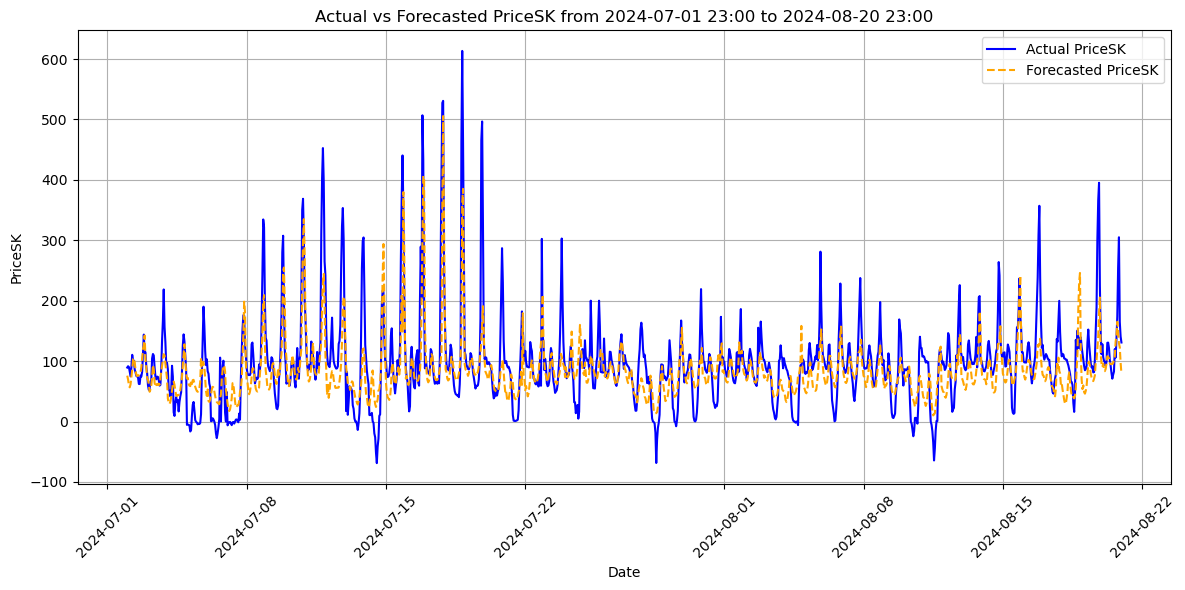

In [22]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['PriceSK'], label='Actual PriceSK', color='blue')
plt.plot(merged_data['Date'], merged_data['yhat'], label='Forecasted PriceSK', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('PriceSK')
plt.title('Actual vs Forecasted PriceSK from 2024-07-01 23:00 to 2024-08-20 23:00')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Engineering Basic

In [23]:
actual_data.head()

,Date,Y,M,Day,H,PriceHU,PriceSK,PriceRO,PriceCZ,PMIHU,GAS,COAL,CO2,COALTOGAS,WDAY,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,Y2016,Y2017,Y2018,Y2019,Y2020,Y2021,Y2022,Y2023,Y2024,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL
0,2015-12-31 23:59:59.995,2016,1,1,1,32.90,16.50,32.90,16.50,49.1,15.3,47.75,7.45,3.120915,1,1,1,1,0,-5.493333,-1.353333,-6.556667,-4.290694,-9.638594,9.506667,70.824667,3403.386667,-1.751667,-5.918333,128.3689,11.33,-7.67,0.0,2.09,0.0,153.7600,12.40,-3.60,0.00,4.42,0.0,249.3241,15.79,-5.21,0.0,5.24,0.0,0.0,25.0,87.0,112.0,125.0,0.0,0.0,0.0,0.0,0,207.0,917.0,1234.0,194,439,0,1219.0,1943.0,0,0,227,227,0,0,0,787,787,0,7210,1524,564.0,232.0,3237.0,4303.0,194.0,358.0,358.0,2135.0,9289.0,0.0,0.0,0.0,445,0,65,510,374.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,330.796471,379.353680,2126.807144,0.0,0.0,-1.972778,562.0,432,432,0,0.0,0.0,2171.643928,6998,8734,4033.0
1,2016-01-01 01:00:00.000,2016,1,1,2,33.34,15.50,33.34,15.50,49.1,15.3,47.75,7.45,3.120915,1,1,1,1,0,-5.503333,-1.353333,-6.556667,-4.290694,-9.638594,9.496667,70.750167,3124.403333,-1.816667,-6.223333,120.1216,10.96,-8.04,0.0,2.06,0.0,161.5441,12.71,-3.29,0.00,3.69,0.0,250.2724,15.82,-5.18,0.0,5.17,0.0,0.0,168.0,87.0,255.0,125.0,0.0,0.0,0.0,0.0,122,956.0,1378.0,2639.0,194,909,0,1514.0,2238.0,0,0,227,227,0,0,0,787,787,0,7210,1524,1156.0,1124.0,3993.0,6146.0,194.0,329.0,329.0,2173.0,8724.0,0.0,0.0,0.0,445,0,65,510,407.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,357.704351,398.913699,2139.439377,0.0,0.0,-2.074444,562.0,432,432,0,0.0,0.0,2185.977244,6446,8734,6273.0
2,2016-01-01 02:00:00.000,2016,1,1,3,30.95,14.00,30.95,14.00,49.1,15.3,47.75,7.45,3.120915,1,1,1,1,0,-5.580000,-1.353333,-6.556667,-4.290694,-9.638594,9.420000,70.179000,3023.820000,-1.894167,-6.475833,112.9969,10.63,-8.37,0.0,2.03,0.0,167.4436,12.94,-3.06,0.00,2.86,0.0,246.1761,15.69,-5.31,0.0,4.85,0.0,0.0,168.0,87.0,255.0,125.0,0.0,0.0,0.0,0.0,122,956.0,1378.0,2639.0,194,909,0,1528.0,2252.0,0,0,227,227,0,0,0,787,787,0,7210,1524,1156.0,1124.0,4007.0,6160.0,194.0,321.0,321.0,2176.0,8694.0,0.0,0.0,0.0,445,0,0,445,357.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,384.642458,418.466355,2152.153538,0.0,0.0,-2.158611,562.0,432,432,0,0.0,0.0,2200.296989,6434,8734,6287.0
3,2016-01-01 03:00:00.000,2016,1,1,4,26.28,10.01,26.28,10.01,49.1,15.3,47.75,7.45,3.120915,1,1,1,1,0,-5.783333,-1.353333,-6.556667,-4.290694,-9.638594,9.216667,68.664167,3142.883333,-1.970833,-6.659167,107.5369,10.37,-8.63,0.0,2.04,0.0,173.7124,13.18,-2.82,0.00,2.14,0.0,228.0100,15.10,-5.90,0.0,4.30,0.0,0.0,168.0,87.0,255.0,125.0,0.0,0.0,0.0,0.0,122,956.0,1378.0,2639.0,194,909,0,1528.0,2252.0,0,0,227,227,0,0,0,787,787,0,7210,1524,1156.0,1124.0,4007.0,6160.0,194.0,341.0,341.0,2180.0,8468.0,0.0,0.0,0.0,445,0,0,445,389.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,411.609123,437.980176,2165.367163,0.0,0.0,-2.219722,562.0,432,432,0,0.0,0.0,2214.584783,63

In [24]:
data = actual_data.copy()

In [25]:
# Define the date range
start_date = pd.to_datetime('2017-01-01 00:00')
cutoff_date = pd.to_datetime("2024-08-20 23:00")

# Filter data within the date range
data = data[(data['Date'] >= start_date) & (data['Date'] <= cutoff_date)]

In [ ]:
# data_new = data_new[data_new['Date'] >= start_date]

# Filter data to only include rows up to the cutoff date
# data_new = data_new[data_new['Date'] <= cutoff_date]

In [26]:
columns_to_drop = [
    'Y', 'M', 'Day', 'H', 'Y2016',	'Y2017',	'Y2018',	'Y2019',	'Y2020',	'Y2021',	'Y2022',	'Y2023',	'Y2024',
    'M1',	'M2',	'M3',	'M4',	'M5',	'M6',	'M7',	'M8',	'M9',	'M10',	'M11',	'M12',
    'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
    'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19',
    'h20', 'h21', 'h22', 'h23', 'h24',
    'PriceCZ', 'PriceSK', 'PriceRO', 'WDAY',
]

In [27]:
data = data.drop(columns=columns_to_drop)

In [ ]:
# data_new = data_new.drop(columns=columns_to_drop)


In [31]:
data['Date'] = data['Date'].dt.round('h')

In [32]:
data.head()

,Date,PriceHU,PMIHU,GAS,COAL,CO2,COALTOGAS,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL
8785,2017-01-01 01:00:00,50.21,52.2,18.75,90.1,4.59,4.805333,1,1,1,1,-6.420000,0.596667,-6.566667,-3.972778,-9.320678,8.580000,39.3822,6323.460000,-1.816667,-5.603333,134.0964,11.58,-7.42,0.0,3.06,0.0,102.6169,10.13,-5.87,0.0,2.17,0.0,225.9009,15.03,-5.97,0.0,3.20,0.0,0.0,287.0,87.0,374.0,0.0,0.0,0.0,110.0,0.0,0,502.0,1881.0,2688.0,361,470,0,1625.0,2000.0,0,0,0,0,0,0,0,787,787,0,8665,3308,470.0,789.0,4380.0,5959.0,361.0,737.0,451.0,2661.0,15447.0,0.0,0.0,0.0,508,0,20,528,497.0,50,768.212097,529.276572,2776.036637,0.0,0.0,-1.867778,426.0,0,831,0,0.0,0.0,2824.859846,12143,11973,5639.0
8786,2017-01-01 02:00:00,44.04,52.2,18.75,90.1,4.59,4.805333,1,1,1,1,-6.380000,0.596667,-6.566667,-4.000556,-9.348456,8.620000,39.5658,5197.860000,-1.894167,-5.635833,131.5609,11.47,-7.53,0.0,3.10,0.0,111.3025,10.55,-5.45,0.0,1.71,0.0,220.2256,14.84,-6.16,0.0,3.28,0.0,0.0,218.0,87.0,305.0,0.0,0.0,0.0,110.0,0.0,0,502.0,1881.0,2688.0,361,470,0,1631.0,2006.0,0,0,0,0,0,0,0,787,787,0,8665,3308,470.0,720.0,4386.0,5896.0,361.0,603.0,316.0,2657.0,15341.0,0.0,0.0,0.0,519,0,20,539,474.0,50,742.385124,523.365848,2724.866331,0.0,0.0,-1.878611,426.0,0,831,0,0.0,0.0,2807.029700,12044,11973,5576.0
8787,2017-01-01 03:00:00,32.81,52.2,18.75,90.1,4.59,4.805333,1,1,1,1,-6.346667,0.596667,-6.566667,-4.007500,-9.355400,8.653333,39.7188,4387.240000,-1.970833,-5.659167,129.2769,11.37,-7.63,0.0,3.08,0.0,114.9184,10.72,-5.28,0.0,1.26,0.0,221.1169,14.87,-6.13,0.0,3.39,0.0,0.0,218.0,0.0,218.0,0.0,0.0,0.0,110.0,0.0,0,502.0,1881.0,2688.0,361,470,0,1631.0,2006.0,0,0,0,0,0,0,0,787,787,0,8665,3308,470.0,720.0,4299.0,5809.0,361.0,507.0,344.0,2608.0,14854.0,0.0,0.0,0.0,519,0,20,539,509.0,50,717.719032,518.821337,2683.314660,0.0,0.0,-1.886389,426.0,0,831,0,0.0,0.0,2789.870447,11559,11973,5489.0
8788,2017-01-01 04:00:00,28.41,52.2,18.75,90.1,4.59,4.805333,1,1,1,1,-6.456667,0.596667,-6.566667,-4.002917,-9.350817,8.543333,39.2139,4357.100000,-2.035833,-5.754167,125.6641,11.21,-7.79,0.0,2.94,0.0,108.9936,10.44,-5.56,0.0,0.97,0.0,224.4004,14.98,-6.02,0.0,3.45,0.0,0.0,218.0,0.0,218.0,0.0,0.0,0.0,110.0,0.0,0,502.0,1881.0,2688.0,361,470,0,1631.0,2006.0,0,0,0,0,0,0,0,787,787,0,8665,3308,470.0,720.0,4299.0,5809.0,361.0,510.0,331.0,2594.0,14951.0,0.0,0.0,0.0,519,0,20,539,499.0,50,695.030977,515.770203,2652.380525,0.0,0.0,-1.918056,426.0,0,831,0,0.0,0.0,2773.645251,11652,11973,5489.0
8789,2017-01-01 05:00:00,24.02,52.2,18.75,90.1,4.59,4.805333,1,1,1,1,-6.566667,0.596667,-6.566667,-3.988889,-9.336789,8.433333,38.7090,3913.066667,-2.140000,-5.740000,123.6544,11.12,-7.88,0.0,2.58,0.0,101.4049,10.07,-5.93,0.0,0.88,0.0,228.3121,15.11,-5.89,0.0,3.50,0.0,0.0,218.0,0.0,218.0,0.0,0.0,0.0,110.0,0.0,0,502.0,1881.0,2688.0,361,470,0,1631.0,2006.0,0,0,0,0,0,0,0,787,787,0,8665,3308,470.0,720.0,4299.0,5809.0,361.0,464.0,335.0,2531.0,15164.0,0.0,0.0,0.0,519,0,20,539,528.0,50,674.903986,514.279327,2632.309682,0.0,0.0,-1.913333,426.0,0,831,0,0.0,0.0,2758.549918,11870,11973,5489.0


In [33]:
def count_nulls_per_column(df, columns):
    # Dictionary to store the number of nulls for each column
    null_counts = {}

    for column in columns:
        # Count the number of nulls in each column
        null_counts[column] = df[column].isnull().sum()

    # Print the total number of nulls for each column
    print("Total number of null values per column:")
    for column, count in null_counts.items():
        print(f"{column}: {count} nulls")

In [34]:
columns_to_check = ['PriceHU', 'COAL', 'GAS', 'AT_HU', 'COALTOGAS', 'CO2', 'UNAVHYDRALL', 'UNAVLIGNSK', 'UNAVHYDRBG', 'Date', 'RHBSOLGEN', 'RORAT_HP','ATWINDGEN']
count_nulls_per_column(data, columns_to_check)

Total number of null values per column:
PriceHU: 0 nulls
COAL: 0 nulls
GAS: 0 nulls
AT_HU: 0 nulls
COALTOGAS: 0 nulls
CO2: 0 nulls
UNAVHYDRALL: 0 nulls
UNAVLIGNSK: 0 nulls
UNAVHYDRBG: 0 nulls
Date: 0 nulls
RHBSOLGEN: 0 nulls
RORAT_HP: 0 nulls
ATWINDGEN: 0 nulls


In [36]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Get the correlations of all columns with 'PriceHU'
price_hu_correlation = correlation_matrix['PriceHU'].sort_values(ascending=False)

# Display the most relevant features that correlate with 'PriceSK'
print(price_hu_correlation)

PriceHU         1.000000
GAS             0.871612
COAL            0.793855
CO2             0.582177
UNAVHYDRBG      0.518509
T2MALLPCO2      0.510297
UNAVGASBG       0.492151
UNAVGASALL      0.486935
UNAVHYDRALL     0.449667
UNAVTPPHU       0.406717
Date            0.406636
UNAVGASHU       0.400937
UNAVGASSK       0.398411
UNAVNUCFR       0.392739
UNAVALLFR       0.367399
UNAVTPPSK       0.315292
UA_SK           0.256427
SOLMAX          0.247859
UNAVGASCZ       0.206753
UNAVHYDRRO      0.181699
UNAVLIGNHU      0.174780
PL_SK           0.164874
PMIHU           0.141359
UNAVTPPBG       0.116580
UNAVHYDRFR      0.109677
UNAVGASGR       0.104828
UNAVNUCHU       0.092012
UADEM           0.090550
T2MALLNONLIN    0.082645
HUSOLGEN        0.073420
T2MROPSQ        0.071165
T2MHUPSQ        0.067655
T2MRO           0.061798
T2MROP          0.061798
T2MSKPSQ        0.059874
T2MALLP         0.055628
T2MALL          0.055628
T2MALLMIN       0.055172
T2MHUP          0.053629
T2MHU           0.053629


In [37]:
# Handling Missing Values
# data = data.interpolate(method='linear')  # Example of linear interpolation
# data = data.interpolate(method='spline', order=3)

# Feature Engineering
data['hour'] = data['Date'].dt.hour
data['day_of_week'] = data['Date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
data['month'] = data['Date'].dt.month
data['rolling_mean_7d'] = data['PriceHU'].rolling(window=7).mean()  # Example of rolling mean
data['lag_1'] = data['PriceHU'].shift(1)  # Example of lag feature

In [38]:
# Lagged Features
data['lag_2'] = data['PriceHU'].shift(2)
data['lag_3'] = data['PriceHU'].shift(3)
data['lag_6'] = data['PriceHU'].shift(6)
data['lag_12'] = data['PriceHU'].shift(12)
data['lag_24'] = data['PriceHU'].shift(24)

In [39]:
# Rolling Statistics
data['rolling_mean_3h'] = data['PriceHU'].rolling(window=3).mean()
data['rolling_mean_12h'] = data['PriceHU'].rolling(window=12).mean()
data['rolling_mean_24h'] = data['PriceHU'].rolling(window=24).mean()

data['rolling_std_3h'] = data['PriceHU'].rolling(window=3).std()
data['rolling_std_12h'] = data['PriceHU'].rolling(window=12).std()
data['rolling_std_24h'] = data['PriceHU'].rolling(window=24).std()

data['ewm_12h'] = data['PriceHU'].ewm(span=12).mean()  # Exponentially weighted moving average with span of 12 hours
data['ewm_24h'] = data['PriceHU'].ewm(span=24).mean()  # Exponentially weighted moving average with span of 24 hours

In [43]:
# Example: Using 'PriceHU' as the target column for FFT
fft_vals = fft(data['PriceHU'].values)

# Compute the magnitude of the FFT components
fft_magnitude = np.abs(fft_vals)

# Identify the top N frequencies with the highest magnitudes
N = 10  # You can adjust this to the number of frequencies you want to keep
top_frequencies = np.argsort(fft_magnitude)[-N:]  # Indices of top N frequencies

# Create features for the magnitudes of the top N frequencies
for i, freq_idx in enumerate(top_frequencies):
    data[f'fft_magnitude_{i+1}'] = fft_magnitude[freq_idx]

print("FFT Features based on top frequencies added to the dataset.")

FFT Features based on top frequencies added to the dataset.


In [44]:
top_frequencies

array([66927,     4, 66931,     3, 66932, 66933,     2, 66934,     1,
           0])

In [48]:
# Select only numeric columns for spline interpolation
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Perform spline interpolation on numeric columns
# data[numeric_columns] = data[numeric_columns].interpolate(method='spline', order=2)

# Verify that there are no NaN values left in numeric columns
print("Number of NaN values after spline interpolation:\n", data[numeric_columns].isna().sum())

Number of NaN values after spline interpolation:
 PriceHU              0
PMIHU                0
GAS                  0
COAL                 0
CO2                  0
COALTOGAS            0
DOFFHU               0
DOFFSK               0
DOFFRO               0
WND                  0
T2MALL               0
T2MALLMAX            0
T2MALLMIN            0
T2MALLAV             0
T2MALLNONLIN         0
T2MALLP              0
T2MALLPCO2           0
T2MALLPROR           0
T2MHUNORM            0
THUDEVNORM           0
T2MHUPSQ             0
T2MHUP               0
T2MHU                0
PRECHU               0
WS10MHU              0
ALLSKY1HU            0
T2MSKPSQ             0
T2MSKP               0
T2MSK                0
PRECSK               0
WS10MSK              0
ALLSKY1SK            0
T2MROPSQ             0
T2MROP               0
T2MRO                0
PRECRO               0
WS10MRO              0
ALLSKY1RO            0
UNAVNUCHU            0
UNAVGASHU            0
UNAVLIGNHU           0
UNAVTPP

In [ ]:
# Drop rows with any remaining NaN values
data = data.dropna()

# Check if all NaN values are handled
print("Number of NaN values after dropping:\n", data.isna().sum())

Number of NaN values after dropping:
 Date                0
PriceHU             0
PMIHU               0
GAS                 0
COAL                0
CO2                 0
COALTOGAS           0
DOFFHU              0
DOFFSK              0
DOFFRO              0
WND                 0
T2MALL              0
T2MALLMAX           0
T2MALLMIN           0
T2MALLAV            0
T2MALLNONLIN        0
T2MALLP             0
T2MALLPCO2          0
T2MALLPROR          0
T2MHUNORM           0
THUDEVNORM          0
T2MHUPSQ            0
T2MHUP              0
T2MHU               0
PRECHU              0
WS10MHU             0
ALLSKY1HU           0
T2MSKPSQ            0
T2MSKP              0
T2MSK               0
PRECSK              0
WS10MSK             0
ALLSKY1SK           0
T2MROPSQ            0
T2MROP              0
T2MRO               0
PRECRO              0
WS10MRO             0
ALLSKY1RO           0
UNAVNUCHU           0
UNAVGASHU           0
UNAVLIGNHU          0
UNAVTPPHU           0
UNAVNUCSK       

In [46]:
# Define your feature matrix X and target variable y
X = data.drop(['PriceHU', 'Date'], axis=1)
y = data['PriceHU']
# Step 1: Feature Importance using RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

In [50]:
data = data.dropna()

In [51]:
# Mutual Information for Feature Selection
X = data.drop(['PriceHU', 'Date'], axis=1)
y = data['PriceHU']

# Ensure all columns are numeric or properly formatted for mutual_info_regression
# X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

mi = mutual_info_regression(X, y)
mi_scores = pd.Series(mi, name="MI Scores", index=X.columns).sort_values(ascending=False)


In [52]:
print(mi_scores)

rolling_mean_3h     1.856059
lag_1               1.765970
lag_2               1.202180
ewm_12h             1.134871
rolling_mean_7d     1.064601
lag_24              1.037132
ewm_24h             0.973630
lag_3               0.908519
rolling_mean_24h    0.902183
GAS                 0.898924
rolling_mean_12h    0.894867
COAL                0.881856
UNAVGASRO           0.784952
PMIHU               0.782551
COALTOGAS           0.756620
CO2                 0.735659
UNAVGASHU           0.691356
UNAVTPPBG           0.672349
UNAVTPPRO           0.620059
UNAVGASALL          0.615897
UNAVLIGNRO          0.607481
UNAVHYDRALL         0.598884
lag_12              0.584388
lag_6               0.577457
UNAVTPPHU           0.564758
UNAVTPPGR           0.556126
UNAVLIGNBG          0.545901
rolling_std_24h     0.536988
UNAVGASGR           0.525794
UNAVHYDRBG          0.504415
SOLMAX              0.464408
UNAVNUCALL          0.463311
UNAVTPPCZ           0.420607
UNAVNUCFR           0.419934
UNAVLIGNCZ    

In [53]:
# Retain top N features based on MI scores
top_features = mi_scores[mi_scores > 0.5].index  # For example, keep features with MI score > 0.5
X_filtered = X[top_features]

In [55]:
X_filtered.describe()

,rolling_mean_3h,lag_1,lag_2,ewm_12h,rolling_mean_7d,lag_24,ewm_24h,lag_3,rolling_mean_24h,GAS,rolling_mean_12h,COAL,UNAVGASRO,PMIHU,COALTOGAS,CO2,UNAVGASHU,UNAVTPPBG,UNAVTPPRO,UNAVGASALL,UNAVLIGNRO,UNAVHYDRALL,lag_12,lag_6,UNAVTPPHU,UNAVTPPGR,UNAVLIGNBG,rolling_std_24h,UNAVGASGR,UNAVHYDRBG
count,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000
mean,96.591436,96.591397,96.590012,96.581072,96.585156,96.555687,96.570200,96.587950,96.571415,39.763270,96.579446,117.056597,652.404762,53.318130,3.959034,42.957564,930.858860,824.503251,1766.216362,2041.543522,960.570190,612.741008,96.569564,96.574735,1275.113527,1297.678977,680.301116,26.056150,669.383151,315.789362
std,97.412747,98.459666,98.459772,93.002584,95.167491,98.447166,91.620283,98.459438,91.676398,44.224628,93.338798,78.980798,294.043176,5.349725,1.399415,29.246506,642.582412,572.088427,958.942230,860.192430,703.022545,516.523945,98.443427,98.443029,733.732684,890.534033,543.030384,25.774253,611.434356,427.020014
min,-188.960000,-500.000000,-500.000000,-74.521555,-94.065714,-500.000000,-20.505231,-500.000000,-0.372500,3.510000,-53.951667,38.600000,0.000000,25.000000,0.817685,0.000000,0.000000,0.000000,0.000000,387.000000,0.000000,0.000000,-500.000000,-500.000000,0.000000,0.000000,0.000000,3.403620,0.000000,0.000000
25%,41.601667,41.200000,41.200000,43.339881,42.383571,41.190000,44.084141,41.200000,44.062083,15.830000,43.190000,67.550000,455.000000,51.800000,3.258496,19.970000,338.000000,354.000000,990.000000,1340.000000,387.000000,194.000000,41.200000,41.200000,682.000000,665.000000,230.000000,10.221937,100.000000,0.000000
50%,62.066667,62.060000,62.060000,61.138211,61.587143,62.040000,61.068215,62.060000,60.977500,22.260000,61.093333,94.350000,566.000000,53.300000,3.807413,28.500000,873.000000,771.000000,1462.000000,1903.000000,799.000000,438.000000,62.050000,62.060000,1204.000000,1157.000000,590.000000,15.975488,568.000000,0.000000
75%,109.878333,109.675000,109.670000,110.225922,110.662143,109.630000,109.678884,109.670000,109.933125,40.040000,110.687917,123.700000,848.000000,56.500000,4.580357,71.290000,1419.000000,1203.000000,2604.000000,2617.000000,1573.000000,995.000000,109.650000,109.660000,1833.000000,1907.000000,1040.000000,33.281570,1041.000000,681.000000
max,1000.663333,1047.100000,1047.100000,864.292678,897.405714,1047.100000,808.278138,1047.100000,759.215833,339.195000,839.373333,438.350000,1507.000000,64.800000,11.025641,97.510000,3536.000000,2864.000000,4402.000000,5109.000000,2803.000000,2537.000000,1047.100000,1047.100000,4382.000000,5154.000000,2654.000000,278.895135,4299.000000,1737.000000


In [56]:
# Calculate the correlation matrix
corr_matrix = X_filtered.corr()

# Identify highly correlated features
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:  # Set your threshold here
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

# Drop highly correlated features
X_uncorrelated = X_filtered.drop(columns=correlated_features)
print("Uncorrelated Features:", X_uncorrelated.columns)

Uncorrelated Features: Index(['rolling_mean_3h', 'UNAVGASRO', 'PMIHU', 'COALTOGAS', 'CO2',
       'UNAVGASHU', 'UNAVTPPBG', 'UNAVTPPRO', 'UNAVGASALL', 'UNAVHYDRALL',
       'UNAVTPPGR', 'rolling_std_24h', 'UNAVGASGR'],
      dtype='object')


In [57]:
# Calculate the correlation matrix
corr_matrix = X_filtered.corr()

# Identify moderately correlated features (0.3 < |correlation| < 0.8)
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
potential_interactions = corr_pairs[(corr_pairs > 0.3) & (corr_pairs < 0.8)]
print("Potential Feature Interactions based on Correlation:\n", potential_interactions)

Potential Feature Interactions based on Correlation:
 lag_1             COAL                0.793816
lag_2             COAL                0.793772
lag_3             COAL                0.793742
lag_6             COAL                0.793687
COAL              lag_12              0.793605
lag_24            COAL                0.793232
UNAVGASRO         UNAVTPPRO           0.738823
UNAVHYDRBG        CO2                 0.726497
rolling_mean_24h  rolling_std_24h     0.712716
rolling_std_24h   ewm_24h             0.711310
UNAVLIGNRO        CO2                 0.707699
ewm_12h           rolling_std_24h     0.702111
rolling_mean_12h  rolling_std_24h     0.699009
CO2               UNAVTPPRO           0.697044
rolling_mean_7d   rolling_std_24h     0.686323
GAS               rolling_std_24h     0.680161
rolling_std_24h   rolling_mean_3h     0.671290
                  lag_1               0.664448
                  lag_2               0.664377
lag_12            rolling_std_24h     0.664198
lag_3 

In [65]:
# Select only numeric columns for spline interpolation
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Perform spline interpolation on numeric columns
# data[numeric_columns] = data[numeric_columns].interpolate(method='spline', order=2)

# Verify that there are no NaN values left in numeric columns
print("Number of NaN values after spline interpolation:\n", data[numeric_columns].isna().sum())

Number of NaN values after spline interpolation:
 PriceHU                               0
PMIHU                                 0
GAS                                   0
COAL                                  0
CO2                                   0
COALTOGAS                             0
DOFFHU                                0
DOFFSK                                0
DOFFRO                                0
WND                                   0
T2MALL                                0
T2MALLMAX                             0
T2MALLMIN                             0
T2MALLAV                              0
T2MALLNONLIN                          0
T2MALLP                               0
T2MALLPCO2                            0
T2MALLPROR                            0
T2MHUNORM                             0
THUDEVNORM                            0
T2MHUPSQ                              0
T2MHUP                                0
T2MHU                                 0
PRECHU                        

In [ ]:
# Drop rows with any remaining NaN values
data = data.dropna()

# Check if all NaN values are handled
print("Number of NaN values after dropping:\n", data.isna().sum())

Number of NaN values after dropping:
 Date                0
PriceHU             0
PMIHU               0
GAS                 0
COAL                0
CO2                 0
COALTOGAS           0
DOFFHU              0
DOFFSK              0
DOFFRO              0
WND                 0
T2MALL              0
T2MALLMAX           0
T2MALLMIN           0
T2MALLAV            0
T2MALLNONLIN        0
T2MALLP             0
T2MALLPCO2          0
T2MALLPROR          0
T2MHUNORM           0
THUDEVNORM          0
T2MHUPSQ            0
T2MHUP              0
T2MHU               0
PRECHU              0
WS10MHU             0
ALLSKY1HU           0
T2MSKPSQ            0
T2MSKP              0
T2MSK               0
PRECSK              0
WS10MSK             0
ALLSKY1SK           0
T2MROPSQ            0
T2MROP              0
T2MRO               0
PRECRO              0
WS10MRO             0
ALLSKY1RO           0
UNAVNUCHU           0
UNAVGASHU           0
UNAVLIGNHU          0
UNAVTPPHU           0
UNAVNUCSK       

In [ ]:
# Convert the 'Date' column to the nearest hour to ensure minutes and seconds are 00
data['Date'] = data['Date'].dt.round('H')

In [59]:
# Print the filtered data to verify
print("\nData from 2017 onwards:")
data.head()



Data from 2017 onwards:


,Date,PriceHU,PMIHU,GAS,COAL,CO2,COALTOGAS,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL,hour,day_of_week,is_weekend,month,rolling_mean_7d,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rolling_mean_3h,rolling_mean_12h,rolling_mean_24h,rolling_std_3h,rolling_std_12h,rolling_std_24h,ewm_12h,ewm_24h,fft_real,fft_imag,fft_magnitude,fft_magnitude_1,fft_magnitude_2,fft_magnitude_3,fft_magnitude_4,fft_magnitude_5,fft_magnitude_6,fft_magnitude_7,fft_magnitude_8,fft_magnitude_9,fft_magnitude_10
8809,2017-01-02 01:00:00,23.45,52.2,19.48,90.1,4.59,4.625257,0,0,1,0,-6.606667,2.286667,-7.54,-4.457500,-9.805400,8.393333,38.5254,3659.493333,-1.267500,-6.112500,135.0244,11.62,-7.38,0.0,2.44,0.0,66.7489,8.17,-7.83,0.0,0.84,0.0,268.6321,16.39,-4.61,0.0,2.75,0.0,0.0,218.0,0.0,218.0,0.0,0.0,0.0,110.0,0.0,0,408.0,1881.0,2594.0,361,470,0,1573.0,1948.0,0,0,0,0,0,0,0,787,787,0,9975,3308,470.0,626.0,4241.0,5657.0,361.0,436.0,676.0,2457.0,12707.0,0.0,0.0,0.0,625,0,20,645,196.0,200,613.779028,565.881159,2537.935776,0.0,0.0,-2.037500,583.0,0,831,0,0.0,0.0,2643.302006,9671,13283,5337.0,1,0,0,1,43.211429,24.84,42.78,43.51,57.97,45.32,50.21,30.356667,46.694167,38.788750,10.781347,12.566432,14.794352,40.999615,41.352244,-189455.927297,185119.353648,264882.471076,748544.106381,848378.303268,848378.303268,1.201238e+06,1.201238e+06,1.908751e+06,1.908751e+06,2.732837e+06,2.732837e+06,6464085.14
8810,2017-01-02 02:00:00,20.89,52.2,19.48,90.1,4.59,4.625257,0,0,1,0,-6.720000,2.286667,-7.54,-4.471667,-9.819567,8.280000,38.0052,3419.640000,-1.427500,-6.112500,131.3316,11.46,-7.54,0.0,2.50,0.0,65.2864,8.08,-7.92,0.0,0.65,0.0,265.6900,16.30,-4.70,0.0,3.03,0.0,0.0,218.0,0.0,218.0,0.0,0.0,0.0,110.0,0.0,0,408.0,1881.0,2594.0,361,470,0,1518.0,1893.0,0,0,0,0,0,0,0,787,787,0,9405,3308,470.0,626.0,4186.0,5602.0,361.0,413.0,513.0,2497.0,12595.0,0.0,0.0,0.0,615,0,20,635,150.0,154,617.722462,560.291994,2525.447526,0.0,0.0,-2.037500,583.0,0,831,0,0.0,0.0,2645.540528,9808,12713,5282.0,2,0,0,1,37.914286,23.45,24.84,42.78,57.96,41.34,44.04,23.060000,44.990000,37.824167,2.003672,14.583319,15.186571,37.865104,39.503771,-137419.905702,-43554.816998,144157.041337,748544.106381,848378.303268,848378.303268,1.201238e+06,1.201238e+06,1.908751e+06,1.908751e+06,2.732837e+06,2.732837e+06,6464085.14
8811,2017-01-02 03:00:00,19.95,52.2,19.48,90.1,4.59,4.625257,0,0,1,0,-6.880000,2.286667,-7.54,-4.493889,-9.841789,8.120000,37.2708,3239.880000,-1.468333,-6.201667,128.3689,11.33,-7.67,0.0,2.62,0.0,67.7329,8.23,-7.77,0.0,0.62,0.0,249.6400,15.80,-5.20,0.0,3.54,0.0,0.0,218.0,0.0,218.0,0.0,0.0,0.0,110.0,0.0,0,408.0,1881.0,2594.0,361,470,0,1518.0,1893.0,0,0,0,0,0,0,0,787,787,0,9405,3308,470.0,626.0,4186.0,5602.0,361.0,399.0,540.0,2446.0,12539.0,0.0,0.0,0.0,615,0,20,635,132.0,200,624.161764,554.497360,2523.263819,0.0,0.0,-2.067222,583.0,0,831,0,0.0,0.0,2649.173154,10039,12713,5282.0,3,0,0,1,32.484286,20.89,23.45,24.84,51.97,44.17,32.81,21.430000,42.971667,37.288333,1.811408,16.283986,15.592624,35.078298,37.755436,62975.698027,-127509.777201,142213.507881,748544.106381,848378.303268,848378.303268,1.201238e+06,1.201238e+06,1.908751e+06,1.908751e+06,2.732837e+06,2.732837e+06,6464085.14
8812,2017-01-02 04:

In [60]:
# Filter pairs to keep only those with moderate correlation (0.3 < |correlation| < 0.8)
selected_pairs = corr_pairs[(corr_pairs.abs() > 0.5) & (corr_pairs.abs() < 0.8)]

In [61]:
# Print the selected feature pairs
print("Selected Feature Pairs for Interaction based on Correlation and Domain Knowledge:")
for (feature_1, feature_2), corr_value in selected_pairs.items():
    # Ensure we print each pair only once
    if feature_1 != feature_2:
        print(f"{feature_1} and {feature_2} with Correlation: {corr_value:.3f}")

Selected Feature Pairs for Interaction based on Correlation and Domain Knowledge:
lag_1 and COAL with Correlation: 0.794
lag_2 and COAL with Correlation: 0.794
lag_3 and COAL with Correlation: 0.794
lag_6 and COAL with Correlation: 0.794
COAL and lag_12 with Correlation: 0.794
lag_24 and COAL with Correlation: 0.793
UNAVGASRO and UNAVTPPRO with Correlation: 0.739
UNAVHYDRBG and CO2 with Correlation: 0.726
rolling_mean_24h and rolling_std_24h with Correlation: 0.713
rolling_std_24h and ewm_24h with Correlation: 0.711
UNAVLIGNRO and CO2 with Correlation: 0.708
ewm_12h and rolling_std_24h with Correlation: 0.702
rolling_mean_12h and rolling_std_24h with Correlation: 0.699
CO2 and UNAVTPPRO with Correlation: 0.697
rolling_mean_7d and rolling_std_24h with Correlation: 0.686
GAS and rolling_std_24h with Correlation: 0.680
rolling_std_24h and rolling_mean_3h with Correlation: 0.671
rolling_std_24h and lag_1 with Correlation: 0.664
rolling_std_24h and lag_2 with Correlation: 0.664
lag_12 and r

In [62]:
# # Creating interaction terms
# for (feature1, feature2) in selected_pairs.index:  # Use .index to get the feature pairs
#     interaction_name = f"{feature1}_x_{feature2}"
#     data[interaction_name] = data[feature1] * data[feature2]

# print("Interaction terms added to the DataFrame.")
# Initialize a dictionary to store interaction terms
interaction_terms = {}

# Create interaction terms for each selected pair
for feature1, feature2 in selected_pairs.index:
    interaction_name = f"{feature1}_x_{feature2}"
    interaction_terms[interaction_name] = data[feature1] * data[feature2]

# Convert the interaction terms dictionary to a DataFrame
interaction_df = pd.DataFrame(interaction_terms)

# Concatenate the original data with the interaction terms DataFrame
data = pd.concat([data, interaction_df], axis=1)

Interaction terms added to the DataFrame.


/var/folders/v9/fvzjlv1s24vc2tkjy7qscjtm0000gn/T/ipykernel_33398/325213071.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[interaction_name] = data[feature1] * data[feature2]
/var/folders/v9/fvzjlv1s24vc2tkjy7qscjtm0000gn/T/ipykernel_33398/325213071.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[interaction_name] = data[feature1] * data[feature2]
/var/folders/v9/fvzjlv1s24vc2tkjy7qscjtm0000gn/T/ipykernel_33398/325213071.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [64]:
data.describe()

,Date,PriceHU,PMIHU,GAS,COAL,CO2,COALTOGAS,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL,hour,day_of_week,is_weekend,month,rolling_mean_7d,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rolling_mean_3h,rolling_mean_12h,rolling_mean_24h,rolling_std_3h,rolling_std_12h,rolling_std_24h,ewm_12h,ewm_24h,fft_real,fft_imag,fft_magnitude,fft_magnitude_1,fft_magnitude_2,fft_magnitude_3,fft_magnitude_4,fft_magnitude_5,fft_magnitude_6,fft_magnitude_7,fft_magnitude_8,fft_magnitude_9,fft_magnitude_10,lag_1_x_COAL,lag_2_x_COAL,lag_3_x_COAL,lag_6_x_COAL,COAL_x_lag_12,lag_24_x_COAL,UNAVGASRO_x_UNAVTPPRO,UNAVHYDRBG_x_CO2,rolling_mean_24h_x_rolling_std_24h,rolling_std_24h_x_ewm_24h,UNAVLIGNRO_x_CO2,ewm_12h_x_rolling_std_24h,rolling_mean_12h_x_rolling_std_24h,CO2_x_UNAVTPPRO,rolling_mean_7d_x_rolling_std_24h,GAS_x_rolling_std_24h,rolling_std_24h_x_rolling_mean_3h,rolling_std_24h_x_lag_1,rolling_std_24h_x_lag_2,lag_12_x_rolling_std_24h,lag_3_x_rolling_std_24h,rolling_std_24h_x_lag_6,lag_24_x_rolling_std_24h,COALTOGAS_x_GAS,CO2_x_COAL,CO2_x_COALTOGAS,COAL_x_rolling_std_24h,UNAVHYDRALL_x_CO2,ewm_24h_x_CO2,rolling_mean_24h_x_CO2,COALTOGAS_x_ewm_24h,COALTOGAS_x_rolling_mean_24h,CO2_x_GAS,ewm_12h_x_CO2,rolling_mean_12h_x_CO2,COALTOGAS_x_ewm_12h,COALTOGAS_x_rolling_mean_12h,rolling_mean_7d_x_CO2,UNAVHYDRBG_x_GAS,COALTOGAS_x_rolling_mean_7d,UNAVGASALL_x_COAL,rolling_mean_3h_x_CO2,CO2_x_rolling_std_24h,COALTOGAS_x_COAL,UNAVHYDRBG_x_COAL,rolling_mean_3h_x_COALTOGAS,UNAVHYDRBG_x_rolling_std_24h,CO2_x_lag_1,CO2_x_lag_2,CO2_x_lag_3,lag_6_x_CO2,lag_24_x_CO2,CO2_x_lag_12,lag_6_x_COALTOGAS,lag_2_x_COALTOGAS,lag_3_x_COALTOGAS,lag_1_x_COALTOGAS,COALTOGAS_x_lag_12,COALTOGAS_x_lag_24,UNAVGASALL_x_GAS,ewm_24h_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_24h,UNAVHYDRBG_x_ewm_12h,UNAVHYDRBG_x_rolling_mean_12h,UNAVTPPBG_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_7d,UNAVGASRO_x_UNAVLIGNRO,rolling_std_24h_x_COALTOGAS,rolling_mean_3h_x_UNAVHYDRBG,rolling_mean_24h_x_UNAVGASALL,CO2_x_UNAVTPPBG,ewm_24h_x_UNAVGASALL,lag_24_x_UNAVHYDRBG,UNAVHYDRBG_x_lag_12,lag_6_x_UNAVHYDRBG,lag_3_x_UNAVHYDRBG,lag_2_x_UNAVHYDRBG,UNAVHYDRALL_x_UNAVTPPBG,UNAVHYDRBG_x_lag_1,UNAVHYDRALL_x_GAS,UNAVGASALL_x_ewm_12h,rolling_std_24h_x_UNAVHYDRALL,UNAVHYDRBG_x_COALTOGAS,rolling_mean_12h_x_UNAVGASALL,UNAVGASALL_x_rolling_mean_7d
count,66911,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.00000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.00000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.000000,66911.

In [66]:
lasso = LassoCV(cv=10)
lasso.fit(X_filtered, y)

# Get the coefficients of the features
lasso_coefficients = pd.Series(lasso.coef_, index=X_filtered.columns).sort_values(ascending=False)

# Filter features based on non-zero coefficients
selected_features = lasso_coefficients[lasso_coefficients != 0].index
X_selected = X_filtered[selected_features]
print("Selected Features based on Lasso:", selected_features)

Selected Features based on Lasso: Index(['rolling_mean_3h', 'lag_24', 'rolling_mean_24h', 'lag_12', 'UNAVHYDRBG',
       'UNAVGASALL', 'UNAVHYDRALL', 'UNAVLIGNRO', 'UNAVLIGNBG', 'lag_3',
       'lag_2'],
      dtype='object')


In [67]:
# Initialize the model
rf = RandomForestRegressor()
rfe = RFE(estimator=rf, n_features_to_select=10)  # Adjust the number of features to keep
rfe.fit(X_filtered, y)

# Get the ranking of features
feature_ranking = pd.Series(rfe.ranking_, index=X_filtered.columns).sort_values()
selected_rfe_features = feature_ranking[feature_ranking == 1].index
print("Selected Features based on RFE:", selected_rfe_features)

Selected Features based on RFE: Index(['rolling_mean_3h', 'lag_1', 'lag_2', 'ewm_12h', 'rolling_std_24h',
       'lag_24', 'ewm_24h', 'lag_3', 'lag_12', 'GAS'],
      dtype='object')


In [68]:
# Step 3: Combine RF Importances and Mutual Information Scores
feature_scores = pd.DataFrame({
    'RandomForestImportance': rf_importances,
    'MutualInformation': mi_scores
})

# Normalize the scores to compare effectively
feature_scores['RF_Score_Norm'] = (feature_scores['RandomForestImportance'] - feature_scores['RandomForestImportance'].min()) / (feature_scores['RandomForestImportance'].max() - feature_scores['RandomForestImportance'].min())
feature_scores['MI_Score_Norm'] = (feature_scores['MutualInformation'] - feature_scores['MutualInformation'].min()) / (feature_scores['MutualInformation'].max() - feature_scores['MutualInformation'].min())


In [69]:
# Calculate a combined score
feature_scores['CombinedScore'] = feature_scores['RF_Score_Norm'] + feature_scores['MI_Score_Norm']

In [70]:
# Select top features based on the combined score
top_features = feature_scores.sort_values('CombinedScore', ascending=False).head(20).index.tolist()

print("Top features for Polynomial Expansion based on combined importance scores:")
print(top_features)

Top features for Polynomial Expansion based on combined importance scores:
['rolling_mean_3h', 'lag_1', 'lag_2', 'ewm_12h', 'rolling_mean_7d', 'lag_24', 'ewm_24h', 'lag_3', 'rolling_mean_24h', 'GAS', 'rolling_mean_12h', 'COAL', 'UNAVGASRO', 'PMIHU', 'COALTOGAS', 'CO2', 'UNAVGASHU', 'UNAVTPPBG', 'UNAVTPPRO', 'UNAVGASALL']


In [71]:
# List of new features to add
# new_features = ['RHBSOLGEN', 'RORAT_HP', 'ATWINDGEN']

# Your existing polynomial features list
polynomial_features = top_features  # Assuming `top_features` is already defined

# Append only the new features that are not already in the list
# polynomial_features.extend([feature for feature in new_features if feature not in polynomial_features])

# Verify the updated list
print("Updated list of features for polynomial expansion:", polynomial_features)

Updated list of features for polynomial expansion: ['rolling_mean_3h', 'lag_1', 'lag_2', 'ewm_12h', 'rolling_mean_7d', 'lag_24', 'ewm_24h', 'lag_3', 'rolling_mean_24h', 'GAS', 'rolling_mean_12h', 'COAL', 'UNAVGASRO', 'PMIHU', 'COALTOGAS', 'CO2', 'UNAVGASHU', 'UNAVTPPBG', 'UNAVTPPRO', 'UNAVGASALL']


In [ ]:
# Drop rows with any remaining NaN values
# data = data.dropna()

In [72]:
# Creating polynomial terms for selected features
# polynomial_features = ['RHBSOLGEN', 'RORAT_HP', 'ATWINDGEN',
# 'rolling_mean_3h',
# 'lag_1',
# 'lag_2',
# 'ewm_12h',
# 'rolling_mean_7d',
# 'lag_24',
# 'ewm_24h',
# 'lag_3',
# 'rolling_mean_24h',
# 'GAS',
# 'rolling_mean_12h',
# 'COAL',
# 'UNAVGASRO',
# 'PMIHU',
# 'COALTOGAS',
# 'CO2']

# Generate polynomial features up to degree 2
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(data[polynomial_features])

# Create a DataFrame for polynomial features
poly_feature_names = poly.get_feature_names_out(polynomial_features)
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Add these polynomial features back to the main DataFrame
data = pd.concat([data, poly_df], axis=1)

print("Created Interaction and Polynomial Features:\n", data.head())

Created Interaction and Polynomial Features:
                     Date  PriceHU  PMIHU    GAS  COAL   CO2  COALTOGAS  \
8809 2017-01-02 01:00:00    23.45   52.2  19.48  90.1  4.59   4.625257   
8810 2017-01-02 02:00:00    20.89   52.2  19.48  90.1  4.59   4.625257   
8811 2017-01-02 03:00:00    19.95   52.2  19.48  90.1  4.59   4.625257   
8812 2017-01-02 04:00:00    22.81   52.2  19.48  90.1  4.59   4.625257   
8813 2017-01-02 05:00:00    26.15   52.2  19.48  90.1  4.59   4.625257   

      DOFFHU  DOFFSK  DOFFRO  WND    T2MALL  T2MALLMAX  T2MALLMIN  T2MALLAV  \
8809     0.0     0.0     1.0  0.0 -6.606667   2.286667      -7.54 -4.457500   
8810     0.0     0.0     1.0  0.0 -6.720000   2.286667      -7.54 -4.471667   
8811     0.0     0.0     1.0  0.0 -6.880000   2.286667      -7.54 -4.493889   
8812     0.0     0.0     1.0  0.0 -7.100000   2.286667      -7.54 -4.520694   
8813     0.0     0.0     1.0  0.0 -7.293333   2.286667      -7.54 -4.550972   

      T2MALLNONLIN   T2MALLP  T2MA

In [74]:
data.head()

,Date,PriceHU,PMIHU,GAS,COAL,CO2,COALTOGAS,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL,hour,day_of_week,is_weekend,month,rolling_mean_7d,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rolling_mean_3h,rolling_mean_12h,rolling_mean_24h,rolling_std_3h,rolling_std_12h,rolling_std_24h,ewm_12h,ewm_24h,fft_real,fft_imag,fft_magnitude,fft_magnitude_1,fft_magnitude_2,fft_magnitude_3,fft_magnitude_4,fft_magnitude_5,fft_magnitude_6,fft_magnitude_7,fft_magnitude_8,fft_magnitude_9,fft_magnitude_10,lag_1_x_COAL,lag_2_x_COAL,lag_3_x_COAL,lag_6_x_COAL,COAL_x_lag_12,lag_24_x_COAL,UNAVGASRO_x_UNAVTPPRO,UNAVHYDRBG_x_CO2,rolling_mean_24h_x_rolling_std_24h,rolling_std_24h_x_ewm_24h,UNAVLIGNRO_x_CO2,ewm_12h_x_rolling_std_24h,rolling_mean_12h_x_rolling_std_24h,CO2_x_UNAVTPPRO,rolling_mean_7d_x_rolling_std_24h,GAS_x_rolling_std_24h,rolling_std_24h_x_rolling_mean_3h,rolling_std_24h_x_lag_1,rolling_std_24h_x_lag_2,lag_12_x_rolling_std_24h,lag_3_x_rolling_std_24h,rolling_std_24h_x_lag_6,lag_24_x_rolling_std_24h,COALTOGAS_x_GAS,CO2_x_COAL,CO2_x_COALTOGAS,COAL_x_rolling_std_24h,UNAVHYDRALL_x_CO2,ewm_24h_x_CO2,rolling_mean_24h_x_CO2,COALTOGAS_x_ewm_24h,COALTOGAS_x_rolling_mean_24h,CO2_x_GAS,ewm_12h_x_CO2,rolling_mean_12h_x_CO2,COALTOGAS_x_ewm_12h,COALTOGAS_x_rolling_mean_12h,rolling_mean_7d_x_CO2,UNAVHYDRBG_x_GAS,COALTOGAS_x_rolling_mean_7d,UNAVGASALL_x_COAL,rolling_mean_3h_x_CO2,CO2_x_rolling_std_24h,COALTOGAS_x_COAL,UNAVHYDRBG_x_COAL,rolling_mean_3h_x_COALTOGAS,UNAVHYDRBG_x_rolling_std_24h,CO2_x_lag_1,CO2_x_lag_2,CO2_x_lag_3,lag_6_x_CO2,lag_24_x_CO2,CO2_x_lag_12,lag_6_x_COALTOGAS,lag_2_x_COALTOGAS,lag_3_x_COALTOGAS,lag_1_x_COALTOGAS,COALTOGAS_x_lag_12,COALTOGAS_x_lag_24,UNAVGASALL_x_GAS,ewm_24h_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_24h,UNAVHYDRBG_x_ewm_12h,UNAVHYDRBG_x_rolling_mean_12h,UNAVTPPBG_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_7d,UNAVGASRO_x_UNAVLIGNRO,rolling_std_24h_x_COALTOGAS,rolling_mean_3h_x_UNAVHYDRBG,rolling_mean_24h_x_UNAVGASALL,CO2_x_UNAVTPPBG,ewm_24h_x_UNAVGASALL,lag_24_x_UNAVHYDRBG,UNAVHYDRBG_x_lag_12,lag_6_x_UNAVHYDRBG,lag_3_x_UNAVHYDRBG,lag_2_x_UNAVHYDRBG,UNAVHYDRALL_x_UNAVTPPBG,UNAVHYDRBG_x_lag_1,UNAVHYDRALL_x_GAS,UNAVGASALL_x_ewm_12h,rolling_std_24h_x_UNAVHYDRALL,UNAVHYDRBG_x_COALTOGAS,rolling_mean_12h_x_UNAVGASALL,UNAVGASALL_x_rolling_mean_7d,rolling_mean_3h,lag_1,lag_2,ewm_12h,rolling_mean_7d,lag_24,ewm_24h,lag_3,rolling_mean_24h,GAS,rolling_mean_12h,COAL,UNAVGASRO,PMIHU,COALTOGAS,CO2,UNAVGASHU,UNAVTPPBG,UNAVTPPRO,UNAVGASALL,rolling_mean_3h^2,rolling_mean_3h lag_1,rolling_mean_3h lag_2,rolling_mean_3h ewm_12h,rolling_mean_3h rolling_mean_7d,rolling_mean_3h lag_24,rolling_mean_3h ewm_24h,rolling_mean_3h lag_3,rolling_mean_3h rolling_mean_24h,rolling_mean_3h GAS,rolling_mean_3h rolling_mean_12h,rolling_mean_3h COAL,rolling_mean_3h UNAVGASRO,rolling_mean_3h PMIHU,rolling_mean_3h COALTOGAS,rolling_mean_3h CO2,rolling_mean_3h UNAVGASHU,rolling_mean_3h UNAVTPPBG,rolling_mean_3h UNAVTPPRO,rolling_mean_3h UNAVGASALL,lag_1^2,lag_1 lag_2,lag_1 ewm_12h,lag_1 rolling_mean_7d,lag_1 lag_24,lag_1 ewm_24h,lag_1 lag_3,lag_1 rolling_mean_24h,lag_1 GAS,lag_1 rolling_mean_12h,lag_1 COAL,lag_1 UNAVGASRO,lag_1 PMIHU,lag_1 COALTOGAS,lag_1 CO2,lag_

In [75]:
# Combining results from different feature selection methods
selected_features_lasso = set(selected_features)
selected_features_rfe = set(selected_rfe_features)
selected_features_mi = set(top_features)

# Find common features across multiple selection methods
final_selected_features = selected_features_lasso.intersection(selected_rfe_features, selected_features_mi)

print("Final Selected Features from Multiple Methods:", final_selected_features)

Final Selected Features from Multiple Methods: {'lag_2', 'lag_24', 'lag_3', 'rolling_mean_3h'}


In [76]:
# Convert the set of final selected features to a list
final_selected_features = list(final_selected_features)

# Calculate the correlation matrix for the final selected features
corr_matrix_final = data[final_selected_features].corr().abs()

# Identify highly correlated features
upper = corr_matrix_final.where(np.triu(np.ones(corr_matrix_final.shape), k=1).astype(bool))
highly_correlated = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop highly correlated features
final_uncorrelated_features = list(set(final_selected_features).difference(set(highly_correlated)))
print("Final Uncorrelated Features for Prophet:", final_uncorrelated_features)

Final Uncorrelated Features for Prophet: []


In [77]:
# Define the target and feature set, excluding the target variable 'PriceSK'
X_poly = data[poly_feature_names]  # This should be your polynomial features DataFrame
y = data['PriceHU']  # Target variable

In [78]:
# Check and handle any remaining NaN values
X_poly = X_poly.ffill().bfill().dropna()
y = y.ffill().bfill().dropna()

# Verify that there are no remaining NaN values
print("Number of NaN values in X_poly:", X_poly.isna().sum().sum())
print("Number of NaN values in y:", y.isna().sum().sum())

Number of NaN values in X_poly: 0
Number of NaN values in y: 0


In [79]:
# # Fit LassoCV model
# lasso = LassoCV(cv=10, random_state=42)
# lasso.fit(X_poly, y)

# # Get selected polynomial features from Lasso
# selected_poly_features = X_poly.columns[(lasso.coef_ != 0)]
# Fit LassoCV model with increased iterations
lasso = LassoCV(cv=10, random_state=42, max_iter=10000)  # Increase max_iter
lasso.fit(X_poly, y)

# Get selected polynomial features from Lasso
selected_poly_features = X_poly.columns[(lasso.coef_ != 0)]
print("Selected Polynomial Features from LASSO:", selected_poly_features)

/opt/anaconda3/envs/lstm-example/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408370.9402848482, tolerance: 63033.47746042123
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/lstm-example/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 634735.3469381332, tolerance: 63033.47746042123
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/lstm-example/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 705567.6539880633, tolerance: 63033.47746042123
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/lstm-example/lib/

Selected Polynomial Features from LASSO: Index(['rolling_mean_3h UNAVGASHU', 'lag_1 UNAVGASRO', 'lag_1 UNAVTPPBG',
       'lag_2 UNAVGASRO', 'lag_24^2', 'lag_24 UNAVGASRO', 'lag_24 UNAVGASHU',
       'lag_24 UNAVTPPBG', 'lag_3 UNAVTPPRO', 'rolling_mean_24h UNAVGASHU',
       'rolling_mean_24h UNAVTPPRO', 'rolling_mean_12h UNAVTPPRO',
       'COAL UNAVTPPBG', 'COAL UNAVTPPRO', 'COAL UNAVGASALL',
       'UNAVGASRO UNAVGASHU', 'UNAVGASRO UNAVTPPBG', 'UNAVGASRO UNAVTPPRO',
       'UNAVGASRO UNAVGASALL', 'CO2 UNAVTPPBG', 'CO2 UNAVTPPRO',
       'CO2 UNAVGASALL', 'UNAVGASHU^2', 'UNAVGASHU UNAVTPPBG',
       'UNAVGASHU UNAVTPPRO', 'UNAVGASHU UNAVGASALL', 'UNAVTPPBG^2',
       'UNAVTPPBG UNAVTPPRO', 'UNAVTPPRO^2', 'UNAVTPPRO UNAVGASALL',
       'UNAVGASALL^2'],
      dtype='object')


/opt/anaconda3/envs/lstm-example/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.202e+07, tolerance: 6.551e+04
  model = cd_fast.enet_coordinate_descent(


In [80]:
# Calculate the correlation matrix for the selected polynomial features
corr_matrix_poly = data[selected_poly_features].corr().abs()

# Identify highly correlated features (correlation > 0.9)
upper_tri = corr_matrix_poly.where(np.triu(np.ones(corr_matrix_poly.shape), k=1).astype(bool))
highly_correlated_poly = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# Drop highly correlated polynomial features
final_poly_features = set(selected_poly_features).difference(set(highly_correlated_poly))
print("Final Selected Polynomial Features:", final_poly_features)

Final Selected Polynomial Features: {'lag_3 UNAVTPPRO', 'CO2 UNAVTPPRO', 'UNAVGASHU UNAVTPPRO', 'UNAVGASRO UNAVGASALL', 'UNAVGASRO UNAVGASHU', 'UNAVGASRO UNAVTPPBG', 'UNAVTPPBG UNAVTPPRO', 'lag_1 UNAVTPPBG', 'CO2 UNAVGASALL', 'UNAVGASHU UNAVTPPBG', 'UNAVTPPRO UNAVGASALL', 'COAL UNAVGASALL', 'rolling_mean_3h UNAVGASHU', 'lag_24^2', 'COAL UNAVTPPBG', 'COAL UNAVTPPRO', 'lag_1 UNAVGASRO', 'UNAVTPPBG^2', 'UNAVGASHU^2', 'UNAVGASRO UNAVTPPRO', 'CO2 UNAVTPPBG'}


In [81]:
# Assuming you have your original final selected features in 'final_uncorrelated_features'
combined_features = list(final_poly_features) + list(final_uncorrelated_features)

print("Combined Features for Prophet:", combined_features)

Combined Features for Prophet: ['lag_3 UNAVTPPRO', 'CO2 UNAVTPPRO', 'UNAVGASHU UNAVTPPRO', 'UNAVGASRO UNAVGASALL', 'UNAVGASRO UNAVGASHU', 'UNAVGASRO UNAVTPPBG', 'UNAVTPPBG UNAVTPPRO', 'lag_1 UNAVTPPBG', 'CO2 UNAVGASALL', 'UNAVGASHU UNAVTPPBG', 'UNAVTPPRO UNAVGASALL', 'COAL UNAVGASALL', 'rolling_mean_3h UNAVGASHU', 'lag_24^2', 'COAL UNAVTPPBG', 'COAL UNAVTPPRO', 'lag_1 UNAVGASRO', 'UNAVTPPBG^2', 'UNAVGASHU^2', 'UNAVGASRO UNAVTPPRO', 'CO2 UNAVTPPBG']


In [86]:
final_regressors = [
    # From Correlation, MI, Lasso, and RFE
    'rolling_mean_3h', 'lag_24', 'rolling_mean_24h', 'lag_12', 'UNAVHYDRBG',
    'UNAVGASALL', 'UNAVHYDRALL', 'UNAVLIGNRO', 'UNAVLIGNBG', 'lag_3', 'lag_2',
    'lag_1', 'ewm_12h', 'ewm_24h', 'GAS', 'COAL', 'CO2',

    # Additional Polynomial Features
    'lag_3 UNAVTPPRO', 'CO2 UNAVTPPRO', 'UNAVGASHU UNAVTPPRO',
    'UNAVGASRO UNAVGASALL', 'UNAVGASRO UNAVGASHU', 'UNAVGASRO UNAVTPPBG',
    'UNAVTPPBG UNAVTPPRO', 'lag_1 UNAVTPPBG', 'CO2 UNAVGASALL',
    'UNAVGASHU UNAVTPPBG', 'UNAVTPPRO UNAVGASALL', 'COAL UNAVGASALL',
    'rolling_mean_3h UNAVGASHU', 'lag_24^2', 'COAL UNAVTPPBG',
    'COAL UNAVTPPRO', 'lag_1 UNAVGASRO', 'UNAVTPPBG^2', 'UNAVGASHU^2',
    'UNAVGASRO UNAVTPPRO', 'CO2 UNAVTPPBG'
]

In [88]:
# Save the full DataFrame with all calculated columns
data.to_csv("/Users/ammarahmad/Documents/Its IT Group/Fuel Price TimeSeries/lstm-example/Prophet/raw_columns_for_training_PriceHU.csv", index=False)

print("All calculated columns saved to CSV successfully!")

All calculated columns saved to CSV successfully!


In [89]:
data.head()

,Date,PriceHU,PMIHU,GAS,COAL,CO2,COALTOGAS,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL,hour,day_of_week,is_weekend,month,rolling_mean_7d,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rolling_mean_3h,rolling_mean_12h,rolling_mean_24h,rolling_std_3h,rolling_std_12h,rolling_std_24h,ewm_12h,ewm_24h,fft_real,fft_imag,fft_magnitude,fft_magnitude_1,fft_magnitude_2,fft_magnitude_3,fft_magnitude_4,fft_magnitude_5,fft_magnitude_6,fft_magnitude_7,fft_magnitude_8,fft_magnitude_9,fft_magnitude_10,lag_1_x_COAL,lag_2_x_COAL,lag_3_x_COAL,lag_6_x_COAL,COAL_x_lag_12,lag_24_x_COAL,UNAVGASRO_x_UNAVTPPRO,UNAVHYDRBG_x_CO2,rolling_mean_24h_x_rolling_std_24h,rolling_std_24h_x_ewm_24h,UNAVLIGNRO_x_CO2,ewm_12h_x_rolling_std_24h,rolling_mean_12h_x_rolling_std_24h,CO2_x_UNAVTPPRO,rolling_mean_7d_x_rolling_std_24h,GAS_x_rolling_std_24h,rolling_std_24h_x_rolling_mean_3h,rolling_std_24h_x_lag_1,rolling_std_24h_x_lag_2,lag_12_x_rolling_std_24h,lag_3_x_rolling_std_24h,rolling_std_24h_x_lag_6,lag_24_x_rolling_std_24h,COALTOGAS_x_GAS,CO2_x_COAL,CO2_x_COALTOGAS,COAL_x_rolling_std_24h,UNAVHYDRALL_x_CO2,ewm_24h_x_CO2,rolling_mean_24h_x_CO2,COALTOGAS_x_ewm_24h,COALTOGAS_x_rolling_mean_24h,CO2_x_GAS,ewm_12h_x_CO2,rolling_mean_12h_x_CO2,COALTOGAS_x_ewm_12h,COALTOGAS_x_rolling_mean_12h,rolling_mean_7d_x_CO2,UNAVHYDRBG_x_GAS,COALTOGAS_x_rolling_mean_7d,UNAVGASALL_x_COAL,rolling_mean_3h_x_CO2,CO2_x_rolling_std_24h,COALTOGAS_x_COAL,UNAVHYDRBG_x_COAL,rolling_mean_3h_x_COALTOGAS,UNAVHYDRBG_x_rolling_std_24h,CO2_x_lag_1,CO2_x_lag_2,CO2_x_lag_3,lag_6_x_CO2,lag_24_x_CO2,CO2_x_lag_12,lag_6_x_COALTOGAS,lag_2_x_COALTOGAS,lag_3_x_COALTOGAS,lag_1_x_COALTOGAS,COALTOGAS_x_lag_12,COALTOGAS_x_lag_24,UNAVGASALL_x_GAS,ewm_24h_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_24h,UNAVHYDRBG_x_ewm_12h,UNAVHYDRBG_x_rolling_mean_12h,UNAVTPPBG_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_7d,UNAVGASRO_x_UNAVLIGNRO,rolling_std_24h_x_COALTOGAS,rolling_mean_3h_x_UNAVHYDRBG,rolling_mean_24h_x_UNAVGASALL,CO2_x_UNAVTPPBG,ewm_24h_x_UNAVGASALL,lag_24_x_UNAVHYDRBG,UNAVHYDRBG_x_lag_12,lag_6_x_UNAVHYDRBG,lag_3_x_UNAVHYDRBG,lag_2_x_UNAVHYDRBG,UNAVHYDRALL_x_UNAVTPPBG,UNAVHYDRBG_x_lag_1,UNAVHYDRALL_x_GAS,UNAVGASALL_x_ewm_12h,rolling_std_24h_x_UNAVHYDRALL,UNAVHYDRBG_x_COALTOGAS,rolling_mean_12h_x_UNAVGASALL,UNAVGASALL_x_rolling_mean_7d,rolling_mean_3h,lag_1,lag_2,ewm_12h,rolling_mean_7d,lag_24,ewm_24h,lag_3,rolling_mean_24h,GAS,rolling_mean_12h,COAL,UNAVGASRO,PMIHU,COALTOGAS,CO2,UNAVGASHU,UNAVTPPBG,UNAVTPPRO,UNAVGASALL,rolling_mean_3h^2,rolling_mean_3h lag_1,rolling_mean_3h lag_2,rolling_mean_3h ewm_12h,rolling_mean_3h rolling_mean_7d,rolling_mean_3h lag_24,rolling_mean_3h ewm_24h,rolling_mean_3h lag_3,rolling_mean_3h rolling_mean_24h,rolling_mean_3h GAS,rolling_mean_3h rolling_mean_12h,rolling_mean_3h COAL,rolling_mean_3h UNAVGASRO,rolling_mean_3h PMIHU,rolling_mean_3h COALTOGAS,rolling_mean_3h CO2,rolling_mean_3h UNAVGASHU,rolling_mean_3h UNAVTPPBG,rolling_mean_3h UNAVTPPRO,rolling_mean_3h UNAVGASALL,lag_1^2,lag_1 lag_2,lag_1 ewm_12h,lag_1 rolling_mean_7d,lag_1 lag_24,lag_1 ewm_24h,lag_1 lag_3,lag_1 rolling_mean_24h,lag_1 GAS,lag_1 rolling_mean_12h,lag_1 COAL,lag_1 UNAVGASRO,lag_1 PMIHU,lag_1 COALTOGAS,lag_1 CO2,lag_

In [93]:
# Combine relevant columns including Date and PriceSK
relevant_columns = ['Date', 'PriceHU'] + final_regressors

In [94]:
final_data = data[relevant_columns]

In [95]:
# Create a copy to avoid the warning
final_data = final_data.copy()

# Convert 'Date' column to datetime format
final_data['Date'] = pd.to_datetime(final_data['Date'], errors='coerce')

# Format 'Date' column properly
final_data['Date'] = final_data['Date'].dt.strftime('%Y-%m-%d %H:%M')

In [ ]:
# # Convert 'Date' column to datetime format
# final_data['Date'] = pd.to_datetime(final_data['Date'], errors='coerce')

# # Ensure the 'Date' column is formatted properly as a string with hours and minutes only
# final_data.loc[:, 'Date'] = final_data['Date'].dt.strftime('%Y-%m-%d %H:%M')  # Format without seconds

In [100]:
final_data.head()

,Date,PriceHU,rolling_mean_3h,rolling_mean_3h,lag_24,lag_24,rolling_mean_24h,rolling_mean_24h,lag_12,UNAVHYDRBG,UNAVGASALL,UNAVGASALL,UNAVHYDRALL,UNAVLIGNRO,UNAVLIGNBG,lag_3,lag_3,lag_2,lag_2,lag_1,lag_1,ewm_12h,ewm_12h,ewm_24h,ewm_24h,GAS,GAS,COAL,COAL,CO2,CO2,lag_3 UNAVTPPRO,CO2 UNAVTPPRO,UNAVGASHU UNAVTPPRO,UNAVGASRO UNAVGASALL,UNAVGASRO UNAVGASHU,UNAVGASRO UNAVTPPBG,UNAVTPPBG UNAVTPPRO,lag_1 UNAVTPPBG,CO2 UNAVGASALL,UNAVGASHU UNAVTPPBG,UNAVTPPRO UNAVGASALL,COAL UNAVGASALL,rolling_mean_3h UNAVGASHU,lag_24^2,COAL UNAVTPPBG,COAL UNAVTPPRO,lag_1 UNAVGASRO,UNAVTPPBG^2,UNAVGASHU^2,UNAVGASRO UNAVTPPRO,CO2 UNAVTPPBG
8809,2017-01-02 01:00,23.45,30.356667,16.023333,50.21,1.09,38.788750,31.352917,45.32,0.0,626.0,1063.0,361.0,1881.0,0.0,43.51,24.16,42.78,24.89,24.84,16.74,40.999615,28.098563,41.352244,30.533711,19.48,19.2,90.1,96.1,4.59,7.07,43198.08,12641.16,591828.0,331656.0,103272.0,0.0,0.0,0.0,7515.41,0.0,1900644.0,102154.3,5303.723333,1.1881,0.0,171826.8,5222.88,0.0,109561.0,557856.0,0.0
8810,2017-01-02 02:00,20.89,23.060000,9.156667,44.04,0.21,37.824167,31.522917,41.34,0.0,626.0,1063.0,361.0,1881.0,0.0,42.78,24.89,24.84,16.74,23.45,6.44,37.865104,24.435707,39.503771,28.434214,19.48,19.2,90.1,96.1,4.59,7.07,44503.32,12641.16,591828.0,331656.0,103272.0,0.0,0.0,0.0,7515.41,0.0,1900644.0,102154.3,3030.856667,0.0441,0.0,171826.8,2009.28,0.0,109561.0,557856.0,0.0
8811,2017-01-02 03:00,19.95,21.430000,7.153333,32.81,0.99,37.288333,31.928750,44.17,0.0,626.0,1063.0,361.0,1881.0,0.0,24.84,16.74,23.45,6.44,20.89,4.29,35.078298,22.327137,37.755436,27.017877,19.48,19.2,90.1,96.1,4.59,7.07,29931.12,12641.16,591828.0,331656.0,103272.0,0.0,0.0,0.0,7515.41,0.0,1900644.0,102154.3,2367.753333,0.9801,0.0,171826.8,1338.48,0.0,109561.0,557856.0,0.0
8812,2017-01-02 04:00,22.81,21.216667,14.806667,28.41,9.91,37.055000,32.740833,52.98,0.0,626.0,1063.0,361.0,1881.0,0.0,23.45,6.44,20.89,4.29,19.95,10.73,33.173146,23.415270,36.431600,27.208447,19.48,19.2,90.1,96.1,4.59,7.07,11514.72,12641.16,591828.0,331656.0,103272.0,0.0,0.0,0.0,7515.41,0.0,1900644.0,102154.3,4901.006667,98.2081,0.0,171826.8,3347.76,0.0,109561.0,557856.0,0.0
8813,2017-01-02 05:00,26.15,22.970000,28.756667,24.02,22.49,37.143750,33.726250,59.68,0.0,626.0,1063.0,361.0,1881.0,0.0,20.89,4.29,19.95,10.73,22.81,29.40,32.084090,26.911382,35.528622,28.722971,19.48,19.2,90.1,96.1,4.59,7.07,7670.52,12641.16,591828.0,331656.0,103272.0,0.0,0.0,0.0,7515.41,0.0,1900644.0,102154.3,9518.456667,505.8001,0.0,171826.8,9172.80,0.0,109561.0,557856.0,0.0


In [99]:
columns_to_check = ['PriceHU', 'lag_24']
count_nulls_per_column(final_data, columns_to_check)

Total number of null values per column:
PriceHU: 8809 nulls
lag_24: lag_24    8809
lag_24    8809
dtype: int64 nulls


In [102]:
# Ensure 'Date' is in datetime format for merging
final_data['Date'] = pd.to_datetime(final_data['Date'], errors='coerce')

# Step 1: Remove duplicate columns in final_data while keeping the first occurrence
final_data = final_data.loc[:, ~final_data.columns.duplicated()]

# Step 2: Merge actual_data with final_data to override values of common columns
# Merge on 'Date' and give preference to 'actual_data' values for common columns
merged_data = pd.merge(final_data, actual_data, on='Date', how='left', suffixes=('', '_actual'))

# Step 3: Replace values in final_data with those from actual_data
for column in actual_data.columns:
    if column != 'Date' and column in merged_data.columns:
        # Override the values in merged_data with the '_actual' suffix columns
        merged_data[column] = merged_data[column + '_actual'].combine_first(merged_data[column])
        # Drop the '_actual' suffix columns after replacing
        merged_data.drop(columns=[column + '_actual'], inplace=True)

# Save the cleaned and merged data back to the CSV
merged_data.to_csv("cleaned_relevant_columns_for_training.csv", index=False)

print("Duplicate columns removed, and values overridden successfully. Saved as 'cleaned_relevant_columns_for_training.csv'.")

KeyError: 'Y_actual'

In [101]:
# Ensure the 'Date' column is formatted properly as a string with hours and minutes only

# Save the DataFrame with relevant columns to CSV
final_data.to_csv("/Users/ammarahmad/Documents/Its IT Group/Fuel Price TimeSeries/lstm-example/Prophet/relevant_columns_for_training_PriceHU.csv", index=False)

print("Relevant columns saved to CSV with correct date format successfully!")

Relevant columns saved to CSV with correct date format successfully!


# Previous Feature Engineering

In [ ]:
# Interaction Features
data['PriceCZ_GAS'] = data['PriceCZ'] * data['GAS']
data['COAL_CO2'] = data['COAL'] * data['CO2']

In [ ]:
# Polynomial Features for Selected Variables
poly = PolynomialFeatures(degree=2, include_bias=False)
selected_features = ['GAS', 'COAL', 'CO2', 'PriceCZ', 'PriceHU']
poly_features = poly.fit_transform(data[selected_features])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(selected_features))


In [ ]:
# Merge Polynomial Features back to the DataFrame
data = pd.concat([data, poly_df], axis=1)

In [ ]:
# Dimensionality Reduction using PCA for Less Significant Features
less_significant_features = ['UNAVTPPRO', 'UNAVGASALL', 'UNAVTPPBG', 'UNAVLIGNRO']
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data[less_significant_features])
pca_df = pd.DataFrame(pca_features, columns=[f'PCA_{i+1}' for i in range(2)])
data = pd.concat([data, pca_df], axis=1)

In [ ]:
# Feature Selection using LASSO
X = data.drop(['PriceSK', 'Date'], axis=1).fillna(0)
y = data['PriceSK']
lasso = LassoCV(cv=10, random_state=42)
lasso.fit(X, y)

LassoCV(cv=10, random_state=42)

In [ ]:
# Get selected features from LASSO
selected_features = X.columns[(lasso.coef_ != 0)]
print("Selected Features from LASSO:", selected_features)

Selected Features from LASSO: Index(['T2MALLPROR', 'UNAVNUCFR', 'DEWINDGEN', 'COAL_CO2', 'GAS PriceCZ',
       'COAL^2', 'COAL CO2', 'COAL PriceHU', 'CO2 PriceCZ', 'CO2 PriceHU',
       'PriceCZ^2', 'PriceHU^2'],
      dtype='object')


# Outliers

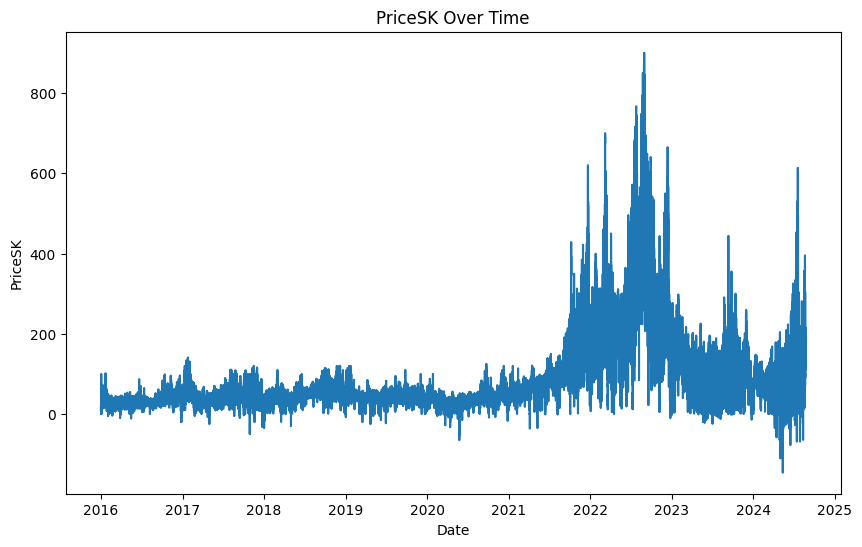

total datapoints 78912


In [ ]:
# Visualize potential outliers in the target variable
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['PriceSK'])
plt.title('PriceSK Over Time')
plt.xlabel('Date')
plt.ylabel('PriceSK')
plt.show()
print(f'total datapoints {len(data)}')

In [ ]:
# Calculate Z-scores for 'PriceSK'
z_scores = np.abs(stats.zscore(data['PriceSK']))

# Identify the indices of outliers (Z-score threshold > 3)
outliers = np.where(z_scores > 3)[0]  # Extract the first element to get the indices array

# Remove outliers from the DataFrame
data = data.drop(data.index[outliers])

# Verify outliers are removed
print("Outliers removed. Remaining data points:", len(data))

Outliers removed. Remaining data points: 78912


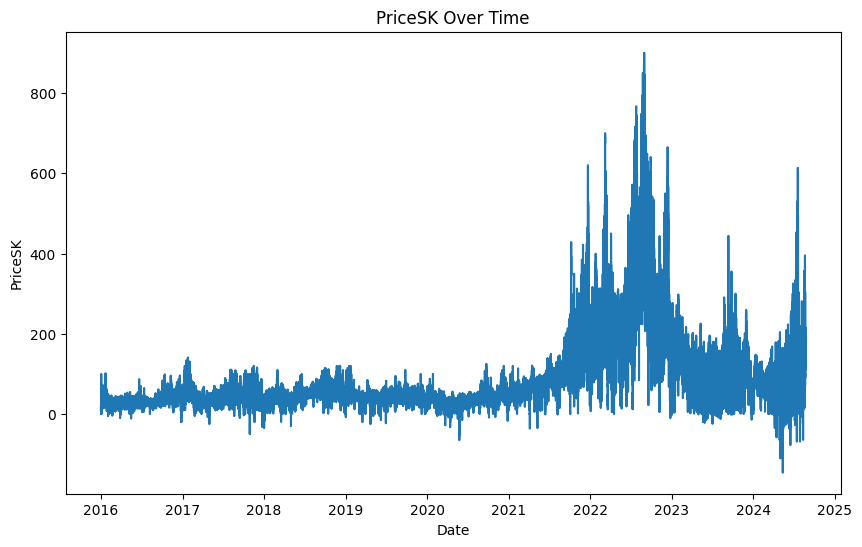

In [ ]:
# Visualize potential outliers in the target variable
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['PriceSK'])
plt.title('PriceSK Over Time')
plt.xlabel('Date')
plt.ylabel('PriceSK')
plt.show()

# Ploting New Features

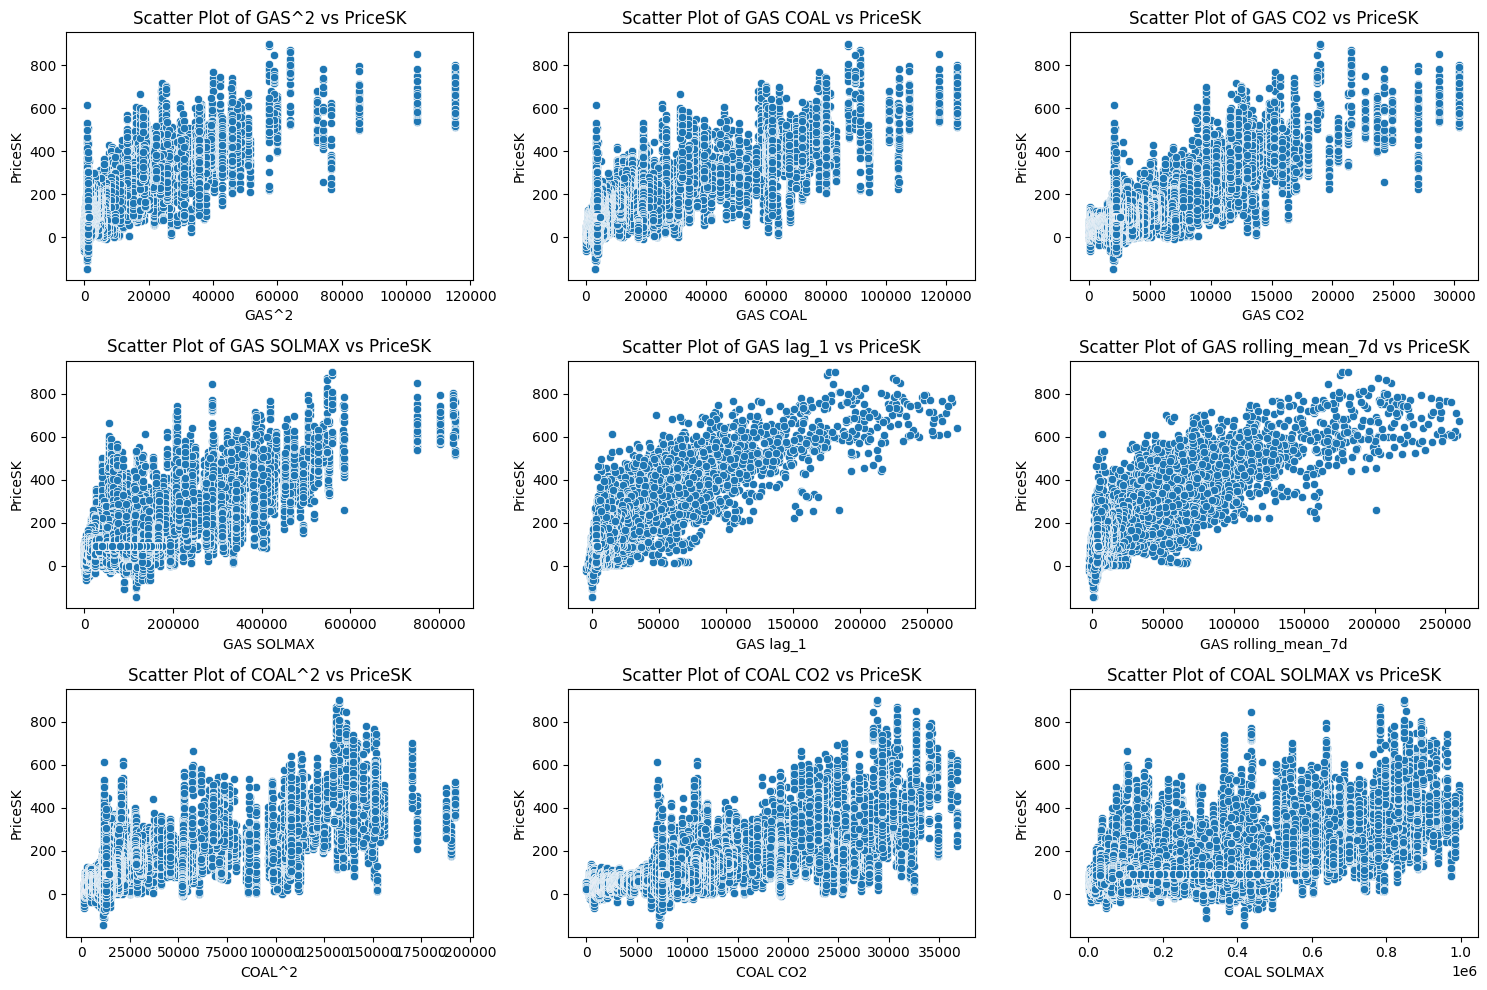

In [ ]:
# Filter out valid polynomial feature names that are 1-dimensional
valid_features = [feature for feature in poly_feature_names if data[feature].ndim == 1]

# Plot some of the new polynomial features against the target variable
plt.figure(figsize=(15, 10))

for i, feature in enumerate(valid_features[:9], 1):  # Limiting to the first 9 features for a 3x3 grid
    plt.subplot(3, 3, i)
    sns.scatterplot(x=data[feature], y=data['PriceSK'])
    plt.title(f'Scatter Plot of {feature} vs PriceSK')

plt.tight_layout()
plt.show()

# date range plotting

In [82]:
# Define the column names to plot
column1 = 'UNAVGASRO UNAVTPPBG'  # Replace with the actual column name
column2 = 'UNAVHYDRBG'  # Replace with the actual column name
column3 = 'UNAVHYDRBG'  # Replace with the actual column name
column4 = 'ATWINDGEN'  # Replace with the actual column name
column5 = 'RORAT_HP'  # Replace with the actual column name
column6 = 'RHBSOLGEN'  # Replace with the actual column name

In [83]:
# Define the date range for which you want to plot the data
start_date = '2018-01-01'  # Replace with the desired start date
end_date = '2018-02-01'  # Replace with the desired end date
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

In [84]:
# Filter data for the specific date range
data_range = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Handle missing values in PriceSK and other columns
data_range['PriceHU'] = data_range['PriceHU'].interpolate(method='linear')
data_range['PriceHU'] = data_range['PriceHU'].bfill().ffill()  # Use bfill() and ffill() directly


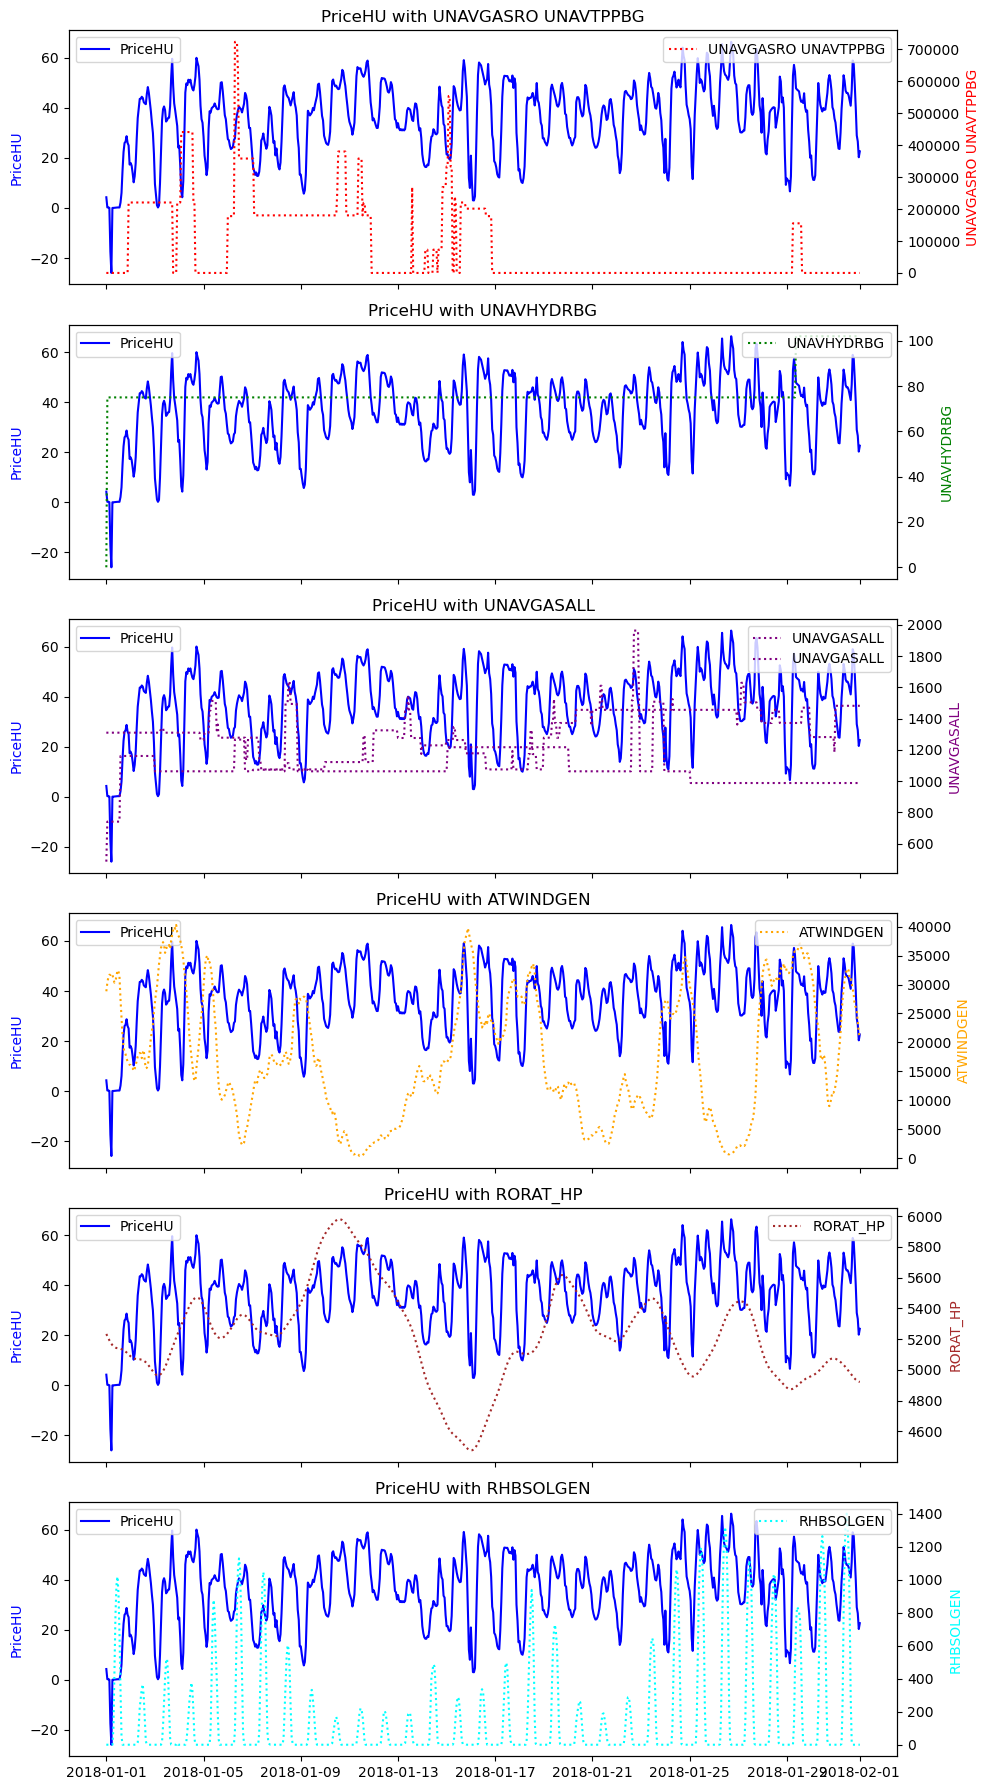

In [85]:
# Initialize a figure with subplots
fig, axes = plt.subplots(6, 1, figsize=(10, 18), sharex=True)  # 6 separate subplots

# Plotting function to create subplots with secondary y-axes
def create_plot(ax, y1, y2, y1_label, y2_label, color1, color2):
    ax.plot(data_range['Date'], data_range[y1], label=y1_label, color=color1, linestyle='-')
    ax.set_ylabel(y1_label, color=color1)
    ax2 = ax.twinx()  # Create a secondary y-axis
    ax2.plot(data_range['Date'], data_range[y2], label=y2_label, color=color2, linestyle=':')
    ax2.set_ylabel(y2_label, color=color2)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.set_title(f'{y1_label} with {y2_label}')

# Create plots for each subplot
create_plot(axes[0], 'PriceHU', column1, 'PriceHU', column1, 'blue', 'red')
create_plot(axes[1], 'PriceHU', column2, 'PriceHU', column2, 'blue', 'green')
create_plot(axes[2], 'PriceHU', column3, 'PriceHU', column3, 'blue', 'purple')
create_plot(axes[3], 'PriceHU', column4, 'PriceHU', column4, 'blue', 'orange')
create_plot(axes[4], 'PriceHU', column5, 'PriceHU', column5, 'blue', 'brown')
create_plot(axes[5], 'PriceHU', column6, 'PriceHU', column6, 'blue', 'cyan')

# Formatting and display
plt.xlabel('Date and Hour')
plt.tight_layout()
plt.show()

# Ploting PriceHU Only

In [ ]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data_interpolated['Date'] = pd.to_datetime(data_interpolated['Date'])

# Define the date range for plotting
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2018-02-01')

# Filter the data within the specified date range
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
filtered_data_interpolated = data_interpolated[(data_interpolated['Date'] >= start_date) & (data_interpolated['Date'] <= end_date)]

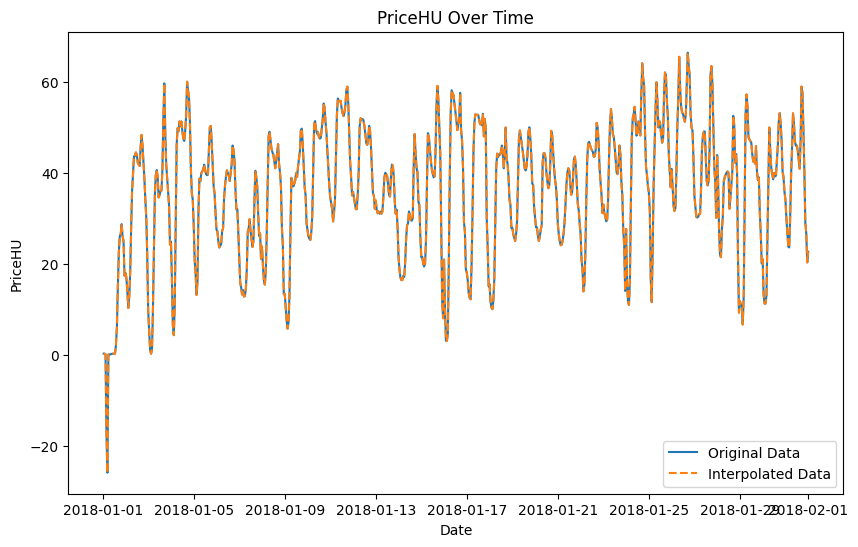

In [ ]:
# Plotting the original and interpolated data
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['Date'], filtered_data['PriceHU'], label='Original Data')
plt.plot(filtered_data_interpolated['Date'], filtered_data_interpolated['PriceHU'], label='Interpolated Data', linestyle='--')

plt.xlabel('Date')
plt.ylabel('PriceHU')
plt.title('PriceHU Over Time')
plt.legend()
plt.show()